In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
## source: https://gist.github.com/foowaa/5b20aebd1dff19ee024b6c72e14347bb
'''
numpy sinusoid position encoding of Transformer model.
params:
n_position(n):number of positions 
d_hid(m): dimension of embedding vector
padding_idx:set 0 dimension
return:
sinusoid_table(n*m):numpy array
'''
def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    '''  '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

   

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return sinusoid_table

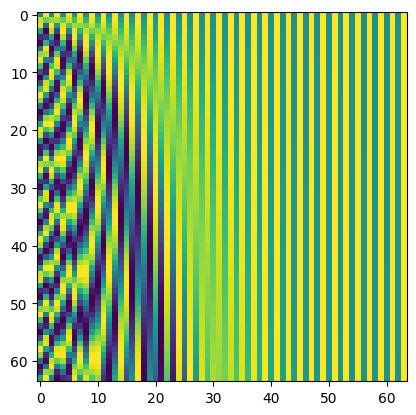

In [3]:
nstep = 64
ndim = 64
data = pd.read_csv("../../data/raw_df.csv")
pos_encodings = get_sinusoid_encoding_table(nstep, ndim)
plt.imshow(pos_encodings)

In [4]:
X = []
y = []
for grp_key, grp in tqdm(data.groupby("file_index_word")):    
    grp = grp.assign(step=np.floor(grp.normalised_t/(1/(nstep-1))).astype("int32"))
    grp_steps = grp.groupby("step").agg(
        n=("pitch", "count"),
        norm_t=("normalised_t", "mean"),
        pitch=("pitch", "mean"))
    feat_vec = np.zeros(ndim)

    for step_i, row in grp_steps.iterrows():
        # feat_vec += row.pitch * pos_encodings[step_i, :]
        feat_vec[step_i] = row.pitch
    X.append(feat_vec)
    y.append(grp.word2.iloc[0])    

  0%|          | 0/2696 [00:00<?, ?it/s]

In [5]:
X = np.vstack(X)
X.shape

(2696, 64)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
trainX, testX, trainY, testY = train_test_split(
    X, y, 
    train_size=.9, 
    stratify=y, 
    random_state=12345)

In [8]:
from sklearn import svm
svc = svm.SVC(C=10)
svc.fit(trainX, trainY)

SVC(C=10)

In [9]:
svc.score(trainX, trainY)

0.9060181368507831

In [10]:
svc.score(testX, testY)

0.22592592592592592

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10, metric="minkowski", p=1)
knn.fit(trainX, trainY)
knn.score(testX, testY)

0.2037037037037037

In [12]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(trainX, trainY)
lsvc.score(testX, testY)

/Users/seantyh/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.08148148148148149

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(trainX, trainY)
lda.score(testX, testY)

0.16296296296296298

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(trainX, trainY)
qda.score(testX, testY)

/Users/seantyh/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.16296296296296298

In [15]:
from sklearn.dummy import DummyClassifier
cls = DummyClassifier(strategy="most_frequent")
cls.fit(trainX, trainY)
cls.score(testX, testY)

0.08148148148148149